# Basic preparations

In this Notebook, the geospatial fabric for the "Bow River at Banff" gauge is extracted from the `MERIT-Basins` dataset.

If you are using Graham HPC, and have access to Clark's Research Group allocation (`rrg-mclark`), you may find `MERIT-Basins` layers under the following path:</br>
`/project/rrg-mclark/data/geospatial-data/MERIT-Basins/`

If you are using Graham HPC, and have access to Global Water Futures Observatories allocation (`rpp-kshook`), you may find `MERIT-Basins` layers under the following path:</br>
`/project/rpp-kshook/Climate_Forcing_Data/geospatial-data/MERIT-Basins`

The version used is `MERIT_Hydro_v07_Basins_v01_bugfix1` which is a directory under the root directory of the dataset.

Let's get started with our workflow and import necessary Python libraries:

In [1]:
import geopandas as gpd # version 0.14.0
import pandas as pd # version 1.4.0
import numpy as np # version 1.22.2
import matplotlib.pyplot as plt # version 3.5.1

from shapely.geometry import Point # version 2.0.1

import hydrant.topology.geom as gm # version 0.1.0-dev1

import subprocess # built-in Python 3.10.2
import os # built-in Python 3.10.2
import glob # built-in Python 3.10.2

`Hydrant` is important in this Notebook. We are only using the `topology.geom`etry module.

Path definitions (system dependant - modify accordingly):

In [2]:
# geofabric paths
## merit-basins provided in `rrg-mclark` - modify as needed
merit_basins_root_path = '/work/comphyd_lab/data/geospatial-data/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1'
merit_basins_geom_path = os.path.join(merit_basins_root_path, 'pfaf_level_02')
merit_basins_nca_path = os.path.join(merit_basins_root_path, 'coastal_hillslopes')

# output paths
output_path = './bow-at-banff-geofabric/'

# Reading `MERIT-Basins` Geospatial Fabric Dataset

## `MERIT-Basins` Geospatial Layers

Upon **visual** inspection (you may use `QGIS` or similar programs), layer #71 has been identified to include necessary sub-basins and river segments for the Bow River at Banff watershed:

As you may see in the cell below, we are using Python `list`s to enable reading multiple layers at once. There are cases where a basin of interest is shared between multiple `pfaf` layers.

For now, let's read the files, one by one:

In [3]:
# file names
# catchments (subbasin)
cat_files = [
    'cat_pfaf_71_MERIT_Hydro_v07_Basins_v01_bugfix1.shp',
]
# rivers (river segments)
riv_files = [
    'riv_pfaf_71_MERIT_Hydro_v07_Basins_v01_bugfix1.shp',
]
# non-contributing catchments (those without any river segments defined for them)
nca_files = [
    'hillslope_71_clean.shp',
]

# reading in data in an iterative manner
cat = pd.concat([gpd.read_file(os.path.join(merit_basins_geom_path, f)) for f in cat_files])
riv = pd.concat([gpd.read_file(os.path.join(merit_basins_geom_path, f)) for f in riv_files])
nca = pd.concat([gpd.read_file(os.path.join(merit_basins_nca_path, f)) for f in nca_files])

Since `MERIT-Basins` layers do not come with correct Coordinate Reference System (CRS) information, we need to specify this manually. The `EPSG` code for the `MERIT-Basins` layer is `4326`. Please refer to the following for more information: https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset

In [4]:
# specifying epsg:4326 for all the MERIT-Basins layers
cat.set_crs(epsg=4326, inplace=True)
nca.set_crs(epsg=4326, inplace=True)
riv.set_crs(epsg=4326, inplace=True)

# Show the EPSG of all geospatial layers
print(f'`cat` CRS: {cat.crs}')
print(f'`riv` CRS: {riv.crs}')
print(f'`nca` CRS: {nca.crs}')

`cat` CRS: EPSG:4326
`riv` CRS: EPSG:4326
`nca` CRS: EPSG:4326


## Bow River At Banff Hydrometric Gauge Location

Based on the information provided by the Water Survery of Canada (WSC), the latitude and longitude of this hydrometric gauge is as follows:

* Latitude:   `51.172397`
* Longitude: `-115.571645`

Based on the information above, we use `hydrant` to extract all the river segment of sub-basins upstream of the coordinates above.

# Preparing `cat`, `riv`, and `nca` objects for `Bow River at Banff`

## Preparing `MERIT-Basins` Layers

Before subsetting the entire layer #71 of the `MERIT-Basins` dataset, we have to assure the layers are ready to be further processed by the `Hydrant` package. Fortunately, `Hydrant` provides necessary functionalities to work with this specific geospatial fabric (applicable to any geospatial fabric in reality). 

In doing so, Hydrant's `geom` module provides the `prepare_cat(...)` function to prepare the `MERIT-Basins` geosptial fabric's sub-basins (or catchments) for the next post-processing steps. Please note that since the non-contributing areas (`nca`) are technically considered sub-basins, they are taken care of using this functionality of `Hydrant`:

In [5]:
# Hydrant's `geom` module provides the `prepare_cat`
# function to prepare the `MERIT-Basins` geosptial
# fabric for next post-processing steps

catchments = gm.prepare_cat(
    cat=cat, # 
    cat_col_id='COMID',
    cst=nca,
    cst_col_mapper={'FID':'COMID'},
    cst_col_id='COMID'
)

# You may see the "docstring" of the `gm.prepare_cat`
# function by running:
# >>> gm.prepare_cat?
# in a separate Jupyter cell (without the >>>), or by
# running simply:
# >>> print(gm.prepare_cat.__doc__)

Similarly, the `geom` module provides the `prepare_riv(...)` function to prepare the `MERIT-Basins` geospatial fabric's river segments for the next post-processing steps:

In [6]:
# Similarly, the `geom` module provides the
# `prepare_riv` function to prepare the `MERIT-Basins`
# geospatial fabric's river segments for the next
# post-processing steps:

rivers = gm.prepare_riv(
    riv=riv,
    riv_cols={
        'id':'COMID',
        'next_id':'NextDownID',
        'slope':'slope',
        'length':'lengthkm',
        'length_direct':'lengthdir'
    },
    cat=catchments,
    cat_cols={
        'id':'COMID',
        'hillslope':'hillslope',
        'geom':'geometry'
    }
)

# You may see the "docstring" of the `gm.prepare_riv`
# function by running:
# >>> gm.prepare_riv?
# in a separate Jupyter cell (without the >>>), or by
# running simply:
# >>> print(gm.prepare_riv.__doc__)

/home/kasra.keshavarz1/virtual-envs/scienv/lib/python3.11/site-packages/hydrant/topology/geom.py:254: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1e-08' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  river.loc[river[hillslope_id] == 1, col_list] = riv_na_val


In Python, you may always access the "docstring" documentations for the functions and classes by running:

```python
>>> print(func.__doc__)
```

Or, if you are working in the Jupyter environment, you may simply run the following in a separate Jupyter cell:
```ipython
[ln1] func?
```

If you are interested in reading up on the functionality of each function used above, use the mentioned methods to print the "docstrings".

Therefore, if you would like to read up on the `gm.prepare_cat(...)` or `gm.prepare_riv(...)` functionality, simply uncomment and execute the following cell:

In [7]:
# gm.prepare_cat?

In [8]:
# gm.prepare_riv?

## Subsetting Sub-basins and River Segments Upstream of the `Bow River at Banff` Hydrometric Station

First, we need to find the `MERIT-Basins`'s sub-basin where this gauge is located. We use `geopandas` capability to do a quick intersection between the two layers (`MERIT-Basins` sub-basins (Multi-)Polygons and `Bow River at Banff` gauge Point).

Based on the information provided earlier, the latitude and longitude of this hydrometric gauge is as follows:

* Latitude:   `51.172397`
* Longitude: `-115.571645`

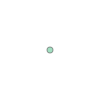

In [9]:
# latitude and longitude values for the
# `Bow River at Banff` Hydrometric gauge
latitude = 51.172397
longitude = -115.571645

# create a Point object
point = Point(longitude, latitude)

# show the `point`
point

In [10]:
print(point)

POINT (-115.571645 51.172397)


Upon building this layer containing only 1 point, let's find the sub-basin that this gauge intersects with:

In [11]:
catchments[catchments.intersects(point)]

,COMID,unitarea,geometry,hillslope
28584,71028585,6.241355,"POLYGON ((-115.57292 51.18542, -115.57208 51.1...",0


Based on the command above, the sub-basin with `COMID` value of `71028585` intersects with the point coordinates of the Bow River at Banff hydrometric gauge.

We may proceed by using the `intersect_topology` to extract whatever located upstream of the sub-basin (and river segment) with `COMID` value of `71028585`.

In [12]:
# `bb` stands for `Bow at Banff`:
bb_catchments, bb_rivers = gm.intersect_topology(
    cat=catchments,
    cat_cols={
        'id':'COMID'
    },
    riv=rivers,
    riv_cols={
        'id':'COMID',
        'next_id':'NextDownID'
    },
    outlet_id=[71028585])

Now, let's plot what have extracted from the larger `MERIT-Basins` geospatial fabric:

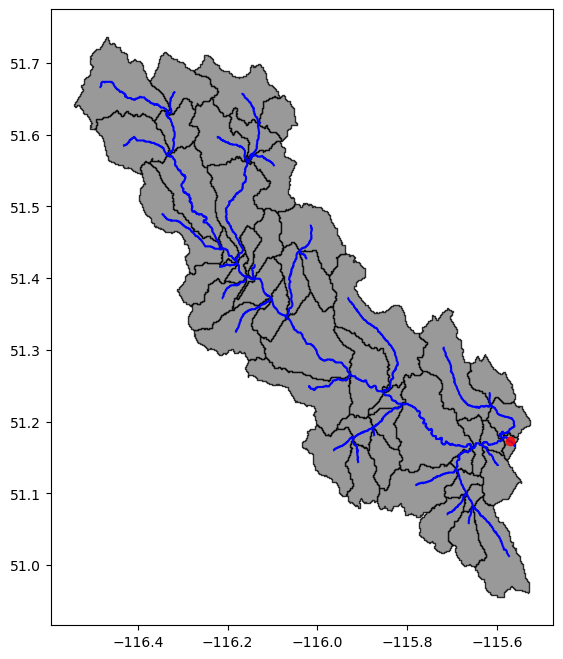

In [13]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(8, 8)
)

# sub-basins
bb_catchments.plot(ax=ax, color='gray', edgecolor='black', alpha=0.8, zorder=1)
# river segments
bb_rivers.plot(ax=ax, color='blue', alpha=1, zorder=2)
# gauge location
ax.scatter(point.x, point.y, color='red', alpha=0.8, zorder=3)

# Saving Extracted Geospatial Fabric upstream of Bow River at Banff Hydrometric Station

In [14]:
# saving the results into the `output_path` directory

# first, creating the directory
try:
    os.makedirs(output_path)
except FileExistsError:
    pass

# then, saving the data
bb_catchments.to_file(os.path.join(output_path, 'bb_subbasins.shp'))
bb_rivers.to_file(os.path.join(output_path, 'bb_rivers.shp'))

___

If you face any issues, e-mail [kasra.keshavarz1 AT ucalgary DOT ca](mailto:kasra.keshavarz1@ucalgary.ca).